## Training Neural Networks

**Contents**
1. PyTorch Tensors
   1. Calculating PyTorch Gradients
2. Building a Simple Neural Network
3. Getting our Data
4. Setting up our training loop
5. Training our model

### Setup/Installations

In [ ]:
!pip install numpy torch

### PyTorch

we use PyTorch to build neural networks because it has support for gradient calculation

In [1]:
# creating a tensor in PyTorch
# Tensor: can be a vector, matrix, etc. but can have more dimensions (3, 4, ...)
import torch

tensor = torch.tensor([[1.2, 1.5], [1.6, 1.7]], requires_grad=True)

In [2]:
# seeing the tensor's contents: a 2x2 matrix
tensor

tensor([[1.2000, 1.5000],
        [1.6000, 1.7000]], requires_grad=True)

In [3]:
x = torch.tensor([[0.5, 0.7]], requires_grad=True)
x

tensor([[0.5000, 0.7000]], requires_grad=True)

In [4]:
# let's do a dot product!
y = x @ tensor
y

tensor([[1.7200, 1.9400]], grad_fn=<MmBackward0>)

In [5]:
# Let's sum the values in the y vector
output = torch.sum(y)
output

tensor(3.6600, grad_fn=<SumBackward0>)

In [6]:
# let's run a backward pass on output, this computes the gradients
output.backward()

In [7]:
# now we can access the gradients of all the computations we did
print(x.grad)
print(tensor.grad)

tensor([[2.7000, 3.3000]])
tensor([[0.5000, 0.5000],
        [0.7000, 0.7000]])


With these automatically generated gradients by a backward pass, we can use them to shift the weights to optimize for a loss function

However, we won't have to access gradients individually like we just did, PyTorch handles a lot of the low-level stuff for us

## Building a Simple Neural Network

We have built a neural network in NumPy before, but PyTorch has prebuilt primitives to make the process much easier, some important things are:
- `torch.nn.Module` - a class we can extend/inherit to create new neural networks
- `torch.nn.Linear` - the equivalent of a linear transformation by a weight and a bias, a simple neural network layer
- `torch.nn.functional.relu` - the relu activation function
- `torch.nn.functional.sigmoid` - the sigmoid activation function

PyTorch handles these low-level computations and allows for robust configuration. It will also automatically compute gradients for all of the operations

In [8]:
from torch import nn, Tensor

class NeuralNetwork(nn.Module): # inheriting from the base PyTorch module class
    def __init__(self, d_in: int, d_hidden: int, d_out: int) -> None: # the initialization function, which takes 3 parameters
        super().__init__() # calls the base constructor for initial setup

        self.linear1 = nn.Linear(in_features=d_in, out_features=d_hidden) # takes an input vector of size d_in, outputs a vector of size d_hidden
        self.linear2 = nn.Linear(in_features=d_hidden, out_features=d_out) # can take input from the previous linear layer to chain together

    def forward(self, x: Tensor) -> Tensor: # this is the method that tells the module what to do with the input
        # NOTE: the size of x must be d_in
        h = self.linear1(x) # first linear projection
        h = nn.functional.relu(h) # relu activation
        out = self.linear2(h) # second linear projection
        out = nn.functional.relu(out)

        return out

In [9]:
# testing out our model

neuralnet = NeuralNetwork(d_in=3, d_hidden=5, d_out=2)

In [10]:
# let's see the weights of our model
neuralnet.linear1.weight

Parameter containing:
tensor([[-0.3724,  0.0054, -0.1612],
        [ 0.3413,  0.2340, -0.5742],
        [ 0.1215, -0.3727, -0.0118],
        [ 0.4999, -0.0333,  0.4688],
        [-0.1525, -0.3231,  0.2787]], requires_grad=True)

In [11]:
# let's see the biases in the second layer of our model
neuralnet.linear2.bias

Parameter containing:
tensor([ 0.3375, -0.2358], requires_grad=True)

In [12]:
# let's run a sample input
x = torch.rand(3)
x

tensor([0.2099, 0.6945, 0.0380])

In [13]:
neuralnet(x)

tensor([0.3838, 0.0000], grad_fn=<ReluBackward0>)

### Getting Data to Train our Model

In [14]:
from sklearn.datasets import load_wine

data_X, data_y = load_wine(return_X_y=True, as_frame=True)
data_X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [15]:
# seeing our dataset's length
len(data_X)

178

In [16]:
# distribution of classes
data_y.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

While SKLearn datasets work well for working with sklearn models, PyTorch datasets (`torch.utils.data.Dataset`) have many utilities that are helpful for training neural networks. Luckily, it is pretty easy to convert between the two

To create a PyTorch dataset, we must create a class that inherits from the base class, such as `class WineDataset(torch.utils.data.Dataset):`

We must then implement the following methods:
- `__init__()` - this initializes the data
- `__len__()` - this returns the length of the data
- `__getitem__(self, index)` - this returns an item at a specific index given as input

In [68]:
from torch.utils.data import Dataset

class WineData(Dataset):
    def __init__(self, data_X, data_y):
        super().__init__() # initial setup by PyTorch

        self.x = data_X.to(dtype=torch.float) #converts to float data type for usability
        self.y = data_y 

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index: int):
        return self.x[index], self.y[index]

After creating these datasets, PyTorch allows us to create DataLoaders (`torch.utils.data.DataLoader`), which can help us retrieve information sequentially or in groups to feed to our model during training

### The Training Loop

While previous methods usually have their training loop under the hood, it's common to write a custom one in PyTorch. We will write a simple loop that consists of looping through the following steps per item in the dataset:

1. Retrieve the input features and expected output from our dataloader
2. Pass the inputs through the model
3. Calculate the loss function given the model's output and the expected output
4. Calculate the **gradients** based on the loss function
5. *Step* the gradients in the direction that minimizes the loss function
   1. We have optimizers that can do this, which PyTorch provides

Some initial setup we'll have to do:
- Setting up our loss function
- Setting up our optimizer
- Setting up storage to hold losses over time

A little bit of terminology:
- Epoch - one full iteration through the dataset, small datasets usually have large numbers of epochs
- Batch - a set of data passed to the model at once. Instead of passing one data item each time, passing multiple allows the model to compute them in parallel
  - Batch sizes are usually powers of 2 to conform to hardware constraints
- Learning rate - determines what percentage of the gradients we alter the weights by
  - e.g. if gradient for a parameter is 10 and the learning rate is 0.01, the model will shift that weight by 0.1
  - Learning rates must be chosen to balance speed but prevent instability

In [69]:
# a function that we can use to organize our data into batches for our model

def collate(x: list[tuple[Tensor, Tensor]]):
    return torch.stack([i[0] for i in x]), torch.stack([i[1] for i in x])

In [102]:
# the training loop!
from torch.utils.data import DataLoader
from tqdm import tqdm

# some config
NUMBER_OF_EPOCHS = 10
BATCH_SIZE = 4
LEARNING_RATE = 0.001

def train(model: NeuralNetwork, data: WineData):
    # setting up our loss function: this is a multiclass classification problem, we'll use cross entropy
    loss_function = nn.CrossEntropyLoss()

    losses = [] # a list to store our losses over time

    # setting up our optimizer, we'll use stochastic gradient descent for this
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUMBER_OF_EPOCHS): # for each iteration in the dataset
        # we'll set up our data for each epoch

        loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate) # shuffling prevents the model from learning the dataset's order over time
        for index, data_item in tqdm(enumerate(loader), desc=f"Training our model on epoch {epoch}:"):
            optimizer.zero_grad() # resets our optimizer after the last gradient step
            input_data, target = data_item # getting the inputs and outputs from the batch

            # compute the outputs of the neural network
            output = model(input_data)

            #compute the loss
            loss = loss_function(output, target) # compares the predicted and expected outputs
            loss.backward() # computes gradients automatically

            losses.append(loss.item()) # adding our loss to the output

            optimizer.step() # alter the weights based on the gradients

    return model, losses

### Data Preprocessing and Scaling

Here, we do our regular train test split. We also scale our data since each feature is in it's own modality (e.g. one feature is in the 100s, while another has a range of 1)

Without scaling, our data can be imbalanced, so we scale it to stabilize our network

In [103]:
# scaling our data to prevent any inconsistencies
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_X)

StandardScaler()

In [104]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2)

# scaling datasets
train_X = torch.tensor(scaler.transform(train_X))
test_X = torch.tensor(scaler.transform(test_X))

In [105]:
# converting to pytorch tensors

train_y = torch.as_tensor(train_y.to_numpy())
test_y = torch.as_tensor(test_y.to_numpy())

### Training our Model

Now that we have all of our parts, we can put them together to ru our training loop

In [106]:
# initializing our Model

n_features = len(data_X.columns)
n_classes = 3

neuralnet = NeuralNetwork(n_features, 6, n_classes)
neuralnet = neuralnet.to(dtype=torch.float)

neuralnet

NeuralNetwork(
  (linear1): Linear(in_features=13, out_features=6, bias=True)
  (linear2): Linear(in_features=6, out_features=3, bias=True)
)

In [107]:
# creating datasets
train_data = WineData(train_X, train_y)
test_data = WineData(test_X, test_y)

In [108]:
# run our train function

model, losses = train(neuralnet, train_data)

Training our model on epoch 0:: 36it [00:00, 218.10it/s]
Training our model on epoch 1:: 36it [00:00, 647.51it/s]
Training our model on epoch 2:: 36it [00:00, 693.06it/s]
Training our model on epoch 3:: 36it [00:00, 730.52it/s]
Training our model on epoch 4:: 36it [00:00, 784.85it/s]
Training our model on epoch 5:: 36it [00:00, 329.13it/s]
Training our model on epoch 6:: 36it [00:00, 727.82it/s]
Training our model on epoch 7:: 36it [00:00, 738.61it/s]
Training our model on epoch 8:: 36it [00:00, 736.51it/s]
Training our model on epoch 9:: 36it [00:00, 774.81it/s]


### Evaluate model on Test Data

To evaluate our model, we first need to get predictions for our data. We can then evaluate with sklearn's classification metric features

In [109]:
y_pred = torch.empty(test_y.size()[0]) # create an empty tensor to hold our predictions. We will predict one-by-one

test_loader = DataLoader(test_data, batch_size=1)

for index, item in tqdm(enumerate(test_loader), desc="testing"):
    input_data, _target = item # getting the inputs and outputs from the batch

    # compute the outputs of the neural network
    output = model(input_data)
    output = torch.argmax(output, dim=-1)
    y_pred[index] = output

y_pred

testing: 36it [00:00, 3989.19it/s]


tensor([1., 1., 0., 0., 2., 0., 2., 2., 1., 1., 2., 0., 1., 1., 2., 1., 1., 0.,
        2., 2., 2., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2., 0.])

In [110]:
test_y

tensor([1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 2, 2, 2, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 2, 0, 2, 2, 0])

<Axes: >

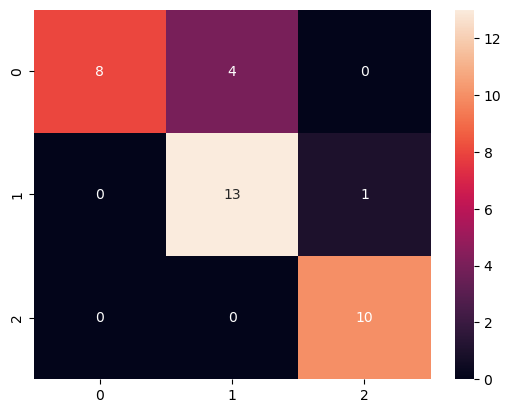

In [111]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

sns.heatmap(confusion_matrix(test_y, y_pred), annot=True)

In [112]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.76      0.93      0.84        14
           2       0.91      1.00      0.95        10

    accuracy                           0.86        36
   macro avg       0.89      0.87      0.86        36
weighted avg       0.88      0.86      0.86        36

